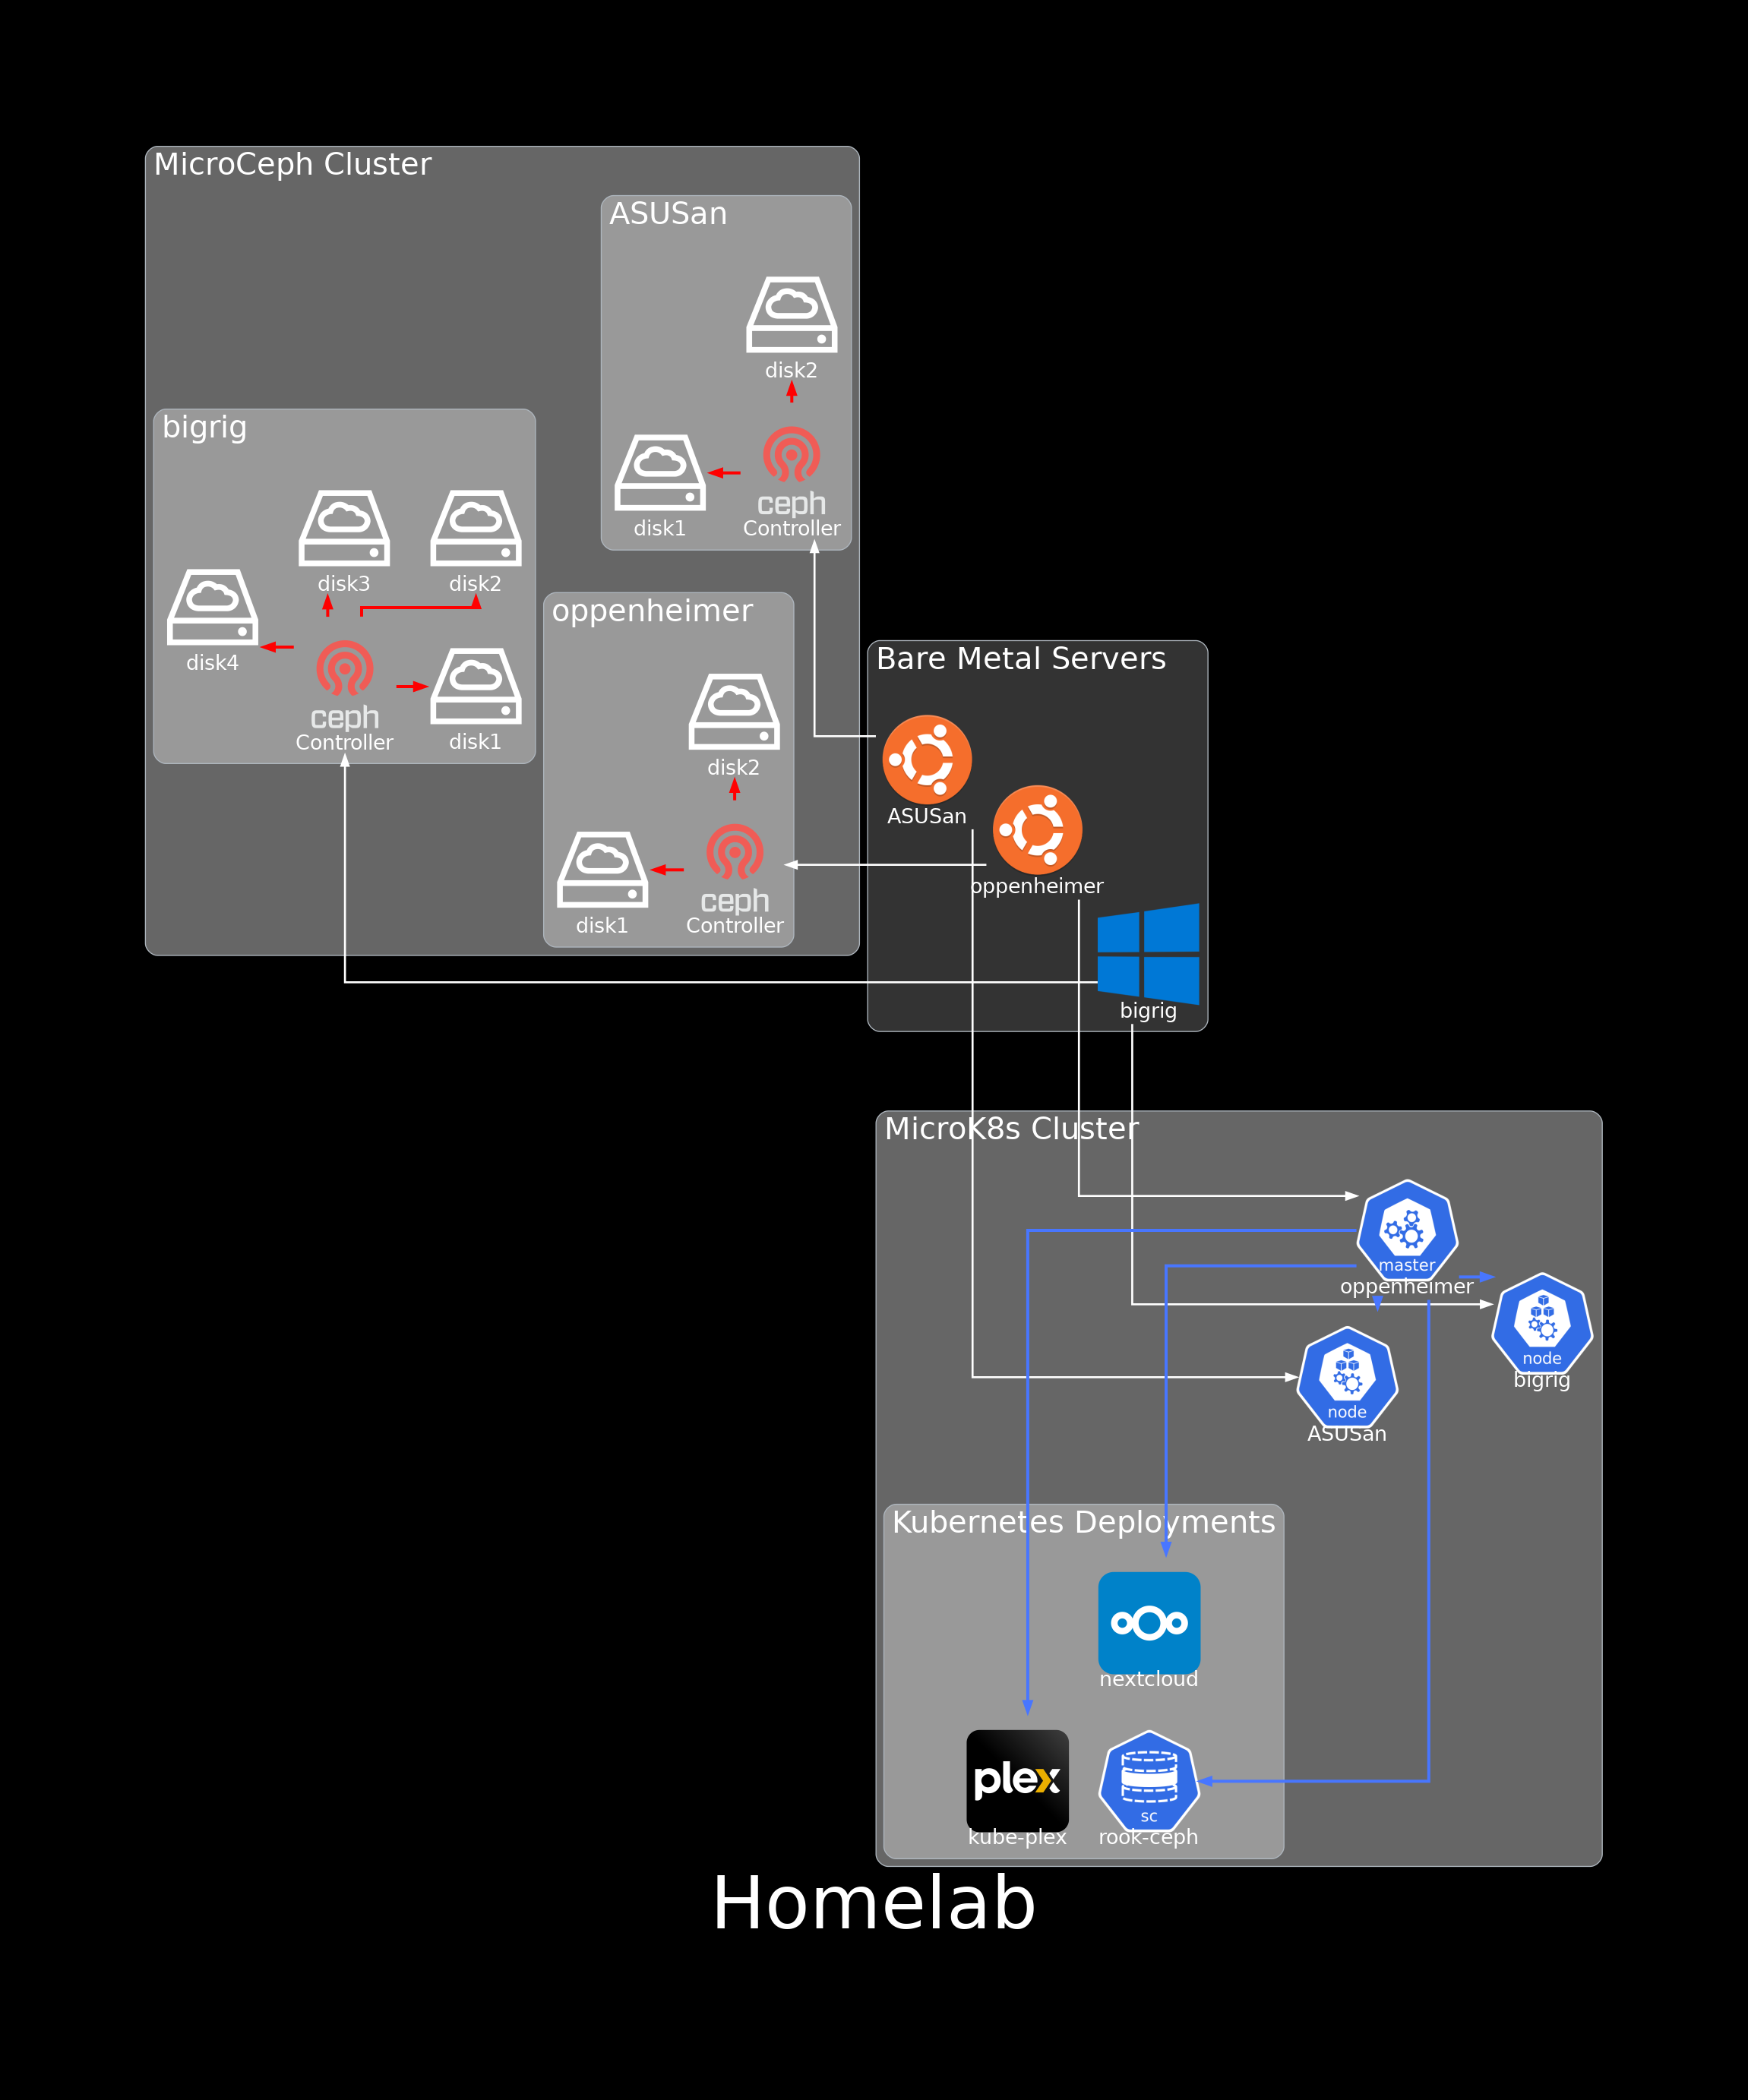

In [36]:
from diagrams               import Diagram, Cluster, Edge
from diagrams.custom        import Custom
from diagrams.generic.os    import Ubuntu, Windows
from diagrams.k8s.infra     import Master, Node
from diagrams.k8s.compute   import Deployment
from diagrams.k8s.storage   import StorageClass
from diagrams.oci.storage   import StorageGatewayWhite

# Attributes
## node
base_node_attr = { "fontcolor": "white", "fontsize": "20" }
## edge
base_edge_attr = { "color": "white", "weight": "120", "penwidth": "2" }
k8s_edge_attr  = base_edge_attr | { "color": "royalblue1", "penwidth": "3" }
ceph_edge_attr = base_edge_attr | { "color": "red", "penwidth": "3" }
## cluster
cluster1_attr  = { "fontcolor": "white", "fontsize": "30", "bgcolor": "gray40" }
baremetal_attr = cluster1_attr | { "bgcolor": "gray20" }
cluster2_attr  = { "fontcolor": "white", "fontsize": "30", "bgcolor": "gray60" }
diagram_attr   = { "fontcolor": "white", "fontsize": "72", "bgcolor": "black", "layout": "fdp", "overlap": "false" }

# Clusters and Nodes
with Diagram("Homelab", graph_attr=diagram_attr) as diag:
    with Cluster("MicroCeph Cluster", graph_attr=cluster1_attr) as microceph:
        with Cluster("bigrig", graph_attr=cluster2_attr) as bigrig_ceph:
            bigrig_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **base_node_attr)
            bigrig_ceph_disk1 = StorageGatewayWhite("disk1", **base_node_attr)
            bigrig_ceph_disk2 = StorageGatewayWhite("disk2", **base_node_attr)
            bigrig_ceph_disk3 = StorageGatewayWhite("disk3", **base_node_attr)
            bigrig_ceph_disk4 = StorageGatewayWhite("disk4", **base_node_attr)

            bigrig_ceph_disks = [bigrig_ceph_disk1, bigrig_ceph_disk2, bigrig_ceph_disk3, bigrig_ceph_disk4]
        
        with Cluster("oppenheimer", graph_attr=cluster2_attr) as oppenheimer_ceph:
            oppenheimer_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **base_node_attr)
            oppenheimer_ceph_disk1 = StorageGatewayWhite("disk1", **base_node_attr)
            oppenheimer_ceph_disk2 = StorageGatewayWhite("disk2", **base_node_attr)

            oppenheimer_ceph_disks = [oppenheimer_ceph_disk1, oppenheimer_ceph_disk2]

        with Cluster("ASUSan", graph_attr=cluster2_attr) as ASUSan_ceph:
            ASUSan_ceph_controller = Custom("Controller", "./custom_icons/ceph.png", **base_node_attr)
            ASUSan_ceph_disk1 = StorageGatewayWhite("disk1", **base_node_attr)
            ASUSan_ceph_disk2 = StorageGatewayWhite("disk2", **base_node_attr)

            ASUSan_ceph_disks = [ASUSan_ceph_disk1, ASUSan_ceph_disk2]

    with Cluster("Bare Metal Servers", graph_attr=baremetal_attr) as baremetal_cluster:
        bigrig      = Windows("bigrig",     **base_node_attr)
        oppenheimer = Ubuntu("oppenheimer", **base_node_attr)
        ASUSan      = Ubuntu("ASUSan",      **base_node_attr)

        baremetal_servers = [oppenheimer, bigrig, ASUSan]

    with Cluster("MicroK8s Cluster", graph_attr=cluster1_attr) as microk8s_cluster:
        master1 = Master("oppenheimer", **base_node_attr)
        node1   = Node("bigrig",        **base_node_attr)
        node2   = Node("ASUSan",        **base_node_attr)

        k8s_nodes = [master1, node1, node2]

        with Cluster("Kubernetes Deployments", graph_attr=cluster2_attr) as k8s_deployments_cluster:
            kube_plex = Custom("kube-plex", "./custom_icons/plex.png", **base_node_attr)
            nextcloud = Custom("nextcloud", "./custom_icons/nextcloud.png", **base_node_attr)
            rook_ceph = StorageClass("rook-ceph", **base_node_attr)

            k8s_deployments = [kube_plex, nextcloud, rook_ceph]

# Edge Connections
    # baremetal nodes to k8s nodes
    oppenheimer >> Edge(**base_edge_attr) >> master1
    bigrig      >> Edge(**base_edge_attr) >> node1
    ASUSan      >> Edge(**base_edge_attr) >> node2
    # baremetal nodes to ceph controllers
    oppenheimer >> Edge(**base_edge_attr) >> oppenheimer_ceph_controller
    bigrig      >> Edge(**base_edge_attr) >> bigrig_ceph_controller
    ASUSan      >> Edge(**base_edge_attr) >> ASUSan_ceph_controller
    # k8s nodes
    master1     >> Edge(**k8s_edge_attr) >> [node1, node2]
    master1     >> Edge(**k8s_edge_attr)  >> k8s_deployments
    # ceph nodes
    oppenheimer_ceph_controller >> Edge(**ceph_edge_attr) >> oppenheimer_ceph_disks
    bigrig_ceph_controller      >> Edge(**ceph_edge_attr) >> bigrig_ceph_disks
    ASUSan_ceph_controller      >> Edge(**ceph_edge_attr) >> ASUSan_ceph_disks

diag